In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ReLU, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
def load_and_preprocess_images(container_dir, secret_dir, target_size=(64, 64), batch_size=32):
    # Load container images without shuffling
    container_ds = tf.keras.preprocessing.image_dataset_from_directory(
        container_dir,
        label_mode=None,
        image_size=target_size,
        batch_size=None,  # Do not batch here
        shuffle=False
    ).map(lambda x: x / 255.0)

    # Load secret images without shuffling
    secret_ds = tf.keras.preprocessing.image_dataset_from_directory(
        secret_dir,
        label_mode=None,
        image_size=target_size,
        batch_size=None,  # Do not batch here
        shuffle=False
    ).map(lambda x: x / 255.0)

    # Zip the two datasets together to form pairs, then batch
    paired_ds = tf.data.Dataset.zip((container_ds, secret_ds))
    paired_ds = paired_ds.batch(batch_size)  # Apply batch after pairing

    return paired_ds

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Conv2D, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define the preparation network to extract features from the container image
def prep_network_layer(container_img):
    # First Conv2D layer with 50 channels and 3x3 kernel
    conv1 = Conv2D(filters=50, kernel_size=(3, 3), strides=(1, 1), padding='same')(container_img)
    conv1 = ReLU()(conv1)

    # Second Conv2D layer with 30 channels and 3x3 kernel
    conv2 = Conv2D(filters=30, kernel_size=(3, 3), strides=(1, 1), padding='same')(conv1)
    conv2 = ReLU()(conv2)

    # Third Conv2D layer with 20 channels and 3x3 kernel
    conv3 = Conv2D(filters=20, kernel_size=(3, 3), strides=(1, 1), padding='same')(conv2)
    conv3 = ReLU()(conv3)
    return conv3

# Define the encoder to embed the secret image within the prepared container features
def encoder(prep_input, secret_img):
    # Adjust the channel dimensions of `secret_img` to match `prep_input` using Conv2D if necessary
    secret_img_adjusted = Conv2D(filters=prep_input.shape[-1], kernel_size=(1, 1), padding='same')(secret_img)

    # Concatenate along the channel axis
    concat_layer = Concatenate(axis=-1)([prep_input, secret_img_adjusted])

    # Continue with the rest of the encoder layers
    conv1 = Conv2D(filters=50, kernel_size=(3, 3), strides=(1, 1), padding='same')(concat_layer)
    conv1 = ReLU()(conv1)

    # Subsequent layers as before
    conv2 = Conv2D(filters=30, kernel_size=(4, 4), strides=(1, 1), padding='same')(conv1)
    conv2 = ReLU()(conv2)

    conv3 = Conv2D(filters=20, kernel_size=(5, 5), strides=(1, 1), padding='same')(conv2)
    conv3 = ReLU()(conv3)

    conv4 = Conv2D(filters=15, kernel_size=(3, 3), strides=(1, 1), padding='same')(conv3)
    conv4 = ReLU()(conv4)

    conv5 = Conv2D(filters=10, kernel_size=(4, 4), strides=(1, 1), padding='same')(conv4)
    conv5 = ReLU()(conv5)

    conv6 = Conv2D(filters=3, kernel_size=(5, 5), strides=(1, 1), padding='same')(conv5)
    output = tf.keras.activations.sigmoid(conv6)

    return output

# Define the decoder to retrieve the secret image from the encoded image
def decoder(encoded_img):
    # Reverse the encoding process to decode the secret image
    conv1 = Conv2D(filters=5, kernel_size=(5, 5), strides=(1, 1), padding='same')(encoded_img)
    conv1 = ReLU()(conv1)
    conv2 = Conv2D(filters=10, kernel_size=(4, 4), strides=(1, 1), padding='same')(conv1)
    conv2 = ReLU()(conv2)
    conv3 = Conv2D(filters=15, kernel_size=(3, 3), strides=(1, 1), padding='same')(conv2)
    conv3 = ReLU()(conv3)
    conv4 = Conv2D(filters=20, kernel_size=(5, 5), strides=(1, 1), padding='same')(conv3)
    conv4 = ReLU()(conv4)
    conv5 = Conv2D(filters=30, kernel_size=(4, 4), strides=(1, 1), padding='same')(conv4)
    conv5 = ReLU()(conv5)
    conv6 = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same')(conv5)
    decoded_img = tf.keras.activations.sigmoid(conv6)

    return decoded_img

# Build the complete model to encode and decode the secret image
container_input = Input(shape=(64, 64, 3), name="container_image")  # Example shape
secret_input = Input(shape=(64, 64, 3), name="secret_image")

# Step 1: Extract features from container image
prep_output = prep_network_layer(container_input)

# Step 2: Encode the secret image
encoded_img = encoder(prep_output, secret_input)

# Step 3: Decode the secret image from the encoded image
decoded_secret_img = decoder(encoded_img)

# Define a model for the full pipeline
full_model = Model(inputs=[container_input, secret_input], outputs=[encoded_img, decoded_secret_img])

# Losses: MSE between container and encoded images + MSE between secret and decoded images
mse_loss = MeanSquaredError()

def custom_loss(y_true, y_pred):
    encoded_loss = mse_loss(y_true[0], y_pred[0])  # Difference between container and encoded image
    decoded_loss = mse_loss(y_true[1], y_pred[1])  # Difference between secret and decoded image
    return encoded_loss + 10 * decoded_loss

# Compile the model with custom loss function and optimizer
full_model.compile(optimizer=Adam(), loss=custom_loss)

# Summary of the full model
full_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ container_image           │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 50)     │          1,400 │ container_image[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 64, 50)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 30)     │         13,530 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 64, 64, 30)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 20)     │          5,420 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ secret_image (InputLayer) │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 20)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 20)     │             80 │ secret_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 40)     │              0 │ re_lu_2[0][0],         │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 50)     │         18,050 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 50)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 30)     │         24,030 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 64, 64, 30)     │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 20)     │         15,020 │ re_lu_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 64, 64, 20)     │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 15)     │          2,715 │ re_lu_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)            │ (None, 64, 64, 15)     │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 103,926 (405.96 KB)

 Trainable params: 103,926 (405.96 KB)

 Non-trainable params: 0 (0.00 B)

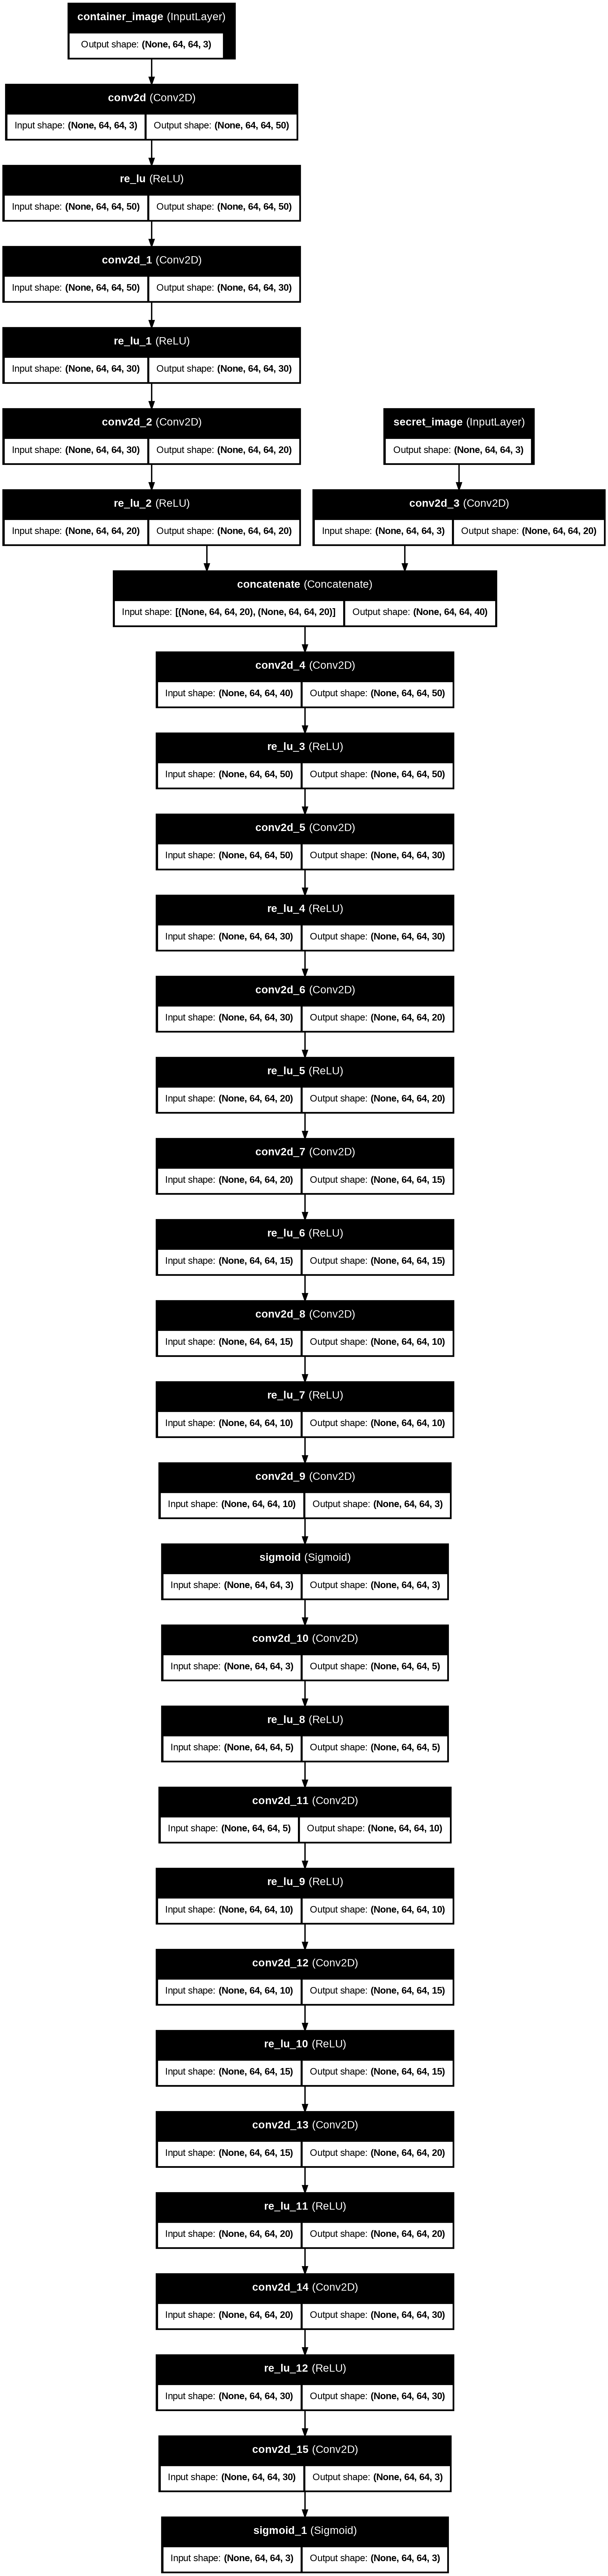

In [4]:
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True)

In [ ]:
def prepare_targets(container_img, secret_img):
    return (container_img, secret_img), (container_img, secret_img)

In [ ]:
container_dir = './Writing'
secret_dir = './jellyfish'

# Load and preprocess images
paired_dataset = load_and_preprocess_images(container_dir, secret_dir, target_size=(64, 64), batch_size=32)

Found 300 files.
Found 150 files.


In [ ]:
paired_dataset = paired_dataset.map(prepare_targets)

In [7]:
full_model.fit(paired_dataset, epochs=2000)

Epoch 1/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 2.8778
Epoch 2/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 2.5841
Epoch 3/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.0932
Epoch 4/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7179
Epoch 5/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3169
Epoch 6/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.1223
Epoch 7/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.9747
Epoch 8/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.9326
Epoch 9/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8701
Epoch 10/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8346
Epoch 11/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8093
Epoch 12/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7934
Epoch 13/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7779
Epoch 14/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7690
Epoch 15/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7598
Epoch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


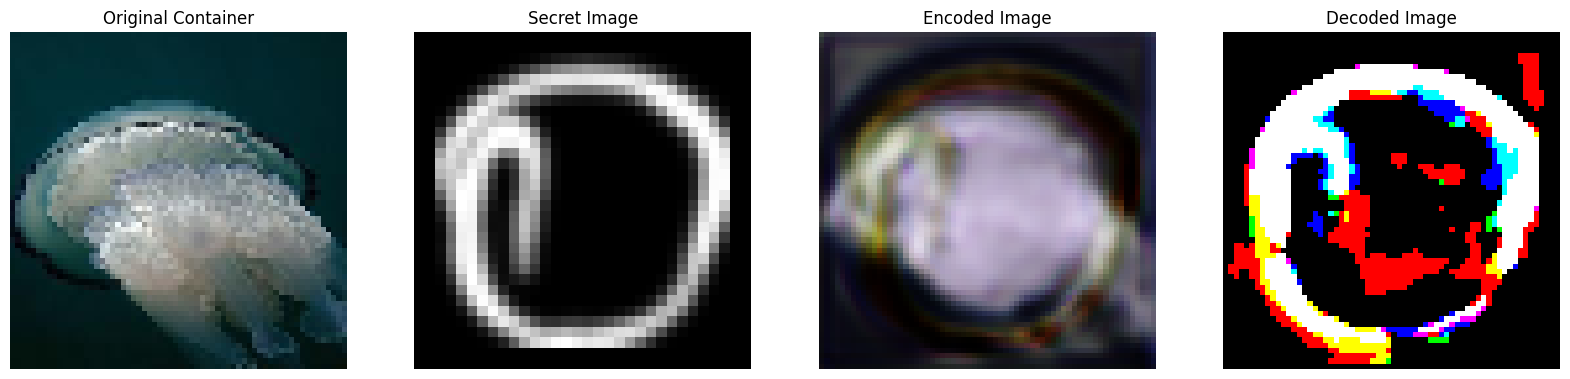

In [14]:
def preprocess_image(image_path, target_size=(64, 64)):
    """Load and preprocess a single image."""
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

def encode_and_decode(encoder_model, decoder_model, container_image, secret_image):
    """Run the models to hide a secret image in a container and then decode it."""
    encoded_image = encoder_model([container_image, secret_image], training=False)  # Pass both images

    # Decode the hidden image from the encoded container
    decoded_image = decoder_model(encoded_image, training=False)  # Decode the encoded image

    return encoded_image, decoded_image

def display_images(container_image, secret_image, encoded_image, decoded_image):
    """Display container, secret, encoded, and decoded images for comparison."""
    weights = np.array([0.2989, 0.5870, 0.1140])
    grayscale_image = np.dot(decoded_image[0][...,:3], weights)
    decoded_image[0] = (decoded_image[0] > 0.5).astype(np.float32)  # Convert to binary
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    titles = ["Original Container", "Secret Image", "Encoded Image", "Decoded Image"]
    images = [container_image, secret_image, encoded_image, decoded_image]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img[0])  # Display the first image in the batch
        ax.set_title(title)
        ax.axis("off")
    plt.show()
model = full_model

# Paths to a sample container and secret image
container_image_path = "/content/jellyfish/03.jpg"
secret_image_path = "/content/Writing/103325.png"



# Preprocess the images
container_image = preprocess_image(container_image_path)
secret_image = preprocess_image(secret_image_path)

# Encode and decode the images
encoded_image, decoded_image = model.predict([container_image, secret_image])

# Display the results
display_images(container_image, secret_image, encoded_image, decoded_image)

In [22]:
tf.keras.models.save_model(full_model, '/content/models/model.keras')